# Functions

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

## Logistic Regression

In [ ]:
class LogisticRegressionSGD (object):
    '''
    Logistic Regression using stochastic gradient descent.
    
    Parameters
    -------------
    learning_rate: float (default=1e-3)
        Learning rate for the stochastic gradient descent.
    random_state: int (default=None)
        Random state used for shuffling the dataset after each iteration.
    penalty: {'l1', 'l2', None} (default='l2')
        Regularization type. 
    C: float (default=1.0)
        Regularization strength.
    max_iter: int (default=100)
        Max iterations for training.
    SGD: boolean (default=False)
        Whether to implement stochastic gradient descent or gradient descent.
    lr_schedule: {int, None} (default=2)
        Number of epochs with no improvement after which learning rate will be reduced.
    lr_schedule_rate: float (default=0.1)
        New learning rate will be the old learning rate multiplied by this number.
    lr_tolerance: float (default=1e-3)
        Threshold of activating the learning rate reduction.
    early_stop: {int, None} (default=4)
        Number of epochs with no improvement after which the training will stop.
    tolerance: float (default=1e-4)
        Threshold of activating the early stop count.
    verbose: {0, 1, 2} (default=0)
        0: no information during training will be printed; 1: loss will be printed after each epoch; 2: loss and learning rate will be printed after each epoch

    Attributes
    -------------
    w: 1-D array
        Weights of the logistic regression model.
    b: 1-D array
        Bias of the logistic regression model
    cost: 1-D array
        Cost function value in each epoch.
    '''
    def __init__(self, learning_rate=1e-3, random_state=None, penalty=None, C=1.0, max_iter=100, SGD=False, lr_schedule=2, lr_schedule_rate=0.1, lr_tolerance=1e-3, early_stop=4, tolerance=1e-4, verbose=0):
        self.learning_rate = learning_rate
        self.random_state = random_state
        self.penalty = penalty
        self.C = C
        self.max_iter = max_iter
        self.SGD = SGD
        self.lr_schedule = lr_schedule
        self.lr_schedule_rate = lr_schedule_rate
        self.lr_tolerance = lr_tolerance
        self.early_stop = early_stop
        self.tolerance = tolerance
        self.verbose = verbose
    
    def fit(self, X, y):
        '''
        Function to train the logistic regression model by finding the optimum weights to minimize the loss.

        Parameters
        ------------
        X: {array-like}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and n_features is the number of features.
        y : array-like, shape = [n_examples]
            Target values.

        Returns
        ------------
        self : object
        '''
        np.random.seed(self.random_state)
        learning_rate = self.learning_rate
        self.loss_epochs = []
        self.w = np.random.normal(loc=0, scale=0.1, size=X.shape[1])
        self.b = np.random.normal(loc=0, scale=0.1, size=1)

        lr_count = 0
        early_stop_count = 0
        for epoch in range(self.max_iter):
          # Shuffle the dataset in each iteration
          indices = np.random.permutation(X.shape[0])
          X_train = X[indices]
          y_train = y[indices]
          loss_epoch = 0
          if self.SGD:
            # Stochastic Gradient Descent
            for i in range(X.shape[0]):
              y_pred = self.predict_proba(X_train[i])
              loss_step = - y_train[i] * np.log(y_pred) - (1 - y_train[i]) * np.log(1 - y_pred)
              if self.penalty == 'l1':
                self.w += learning_rate * (y_train[i] - y_pred) * X_train[i] + self.C * np.sign(self.w)
                self.b += learning_rate * (y_train[i] - y_pred)   # Bias is not regularized
              elif self.penalty == 'l2':
                self.w += learning_rate * (y_train[i] - y_pred) * X_train[i] + self.C * self.w
                self.b += learning_rate * (y_train[i] - y_pred)   # Bias is not regularized
              else:
                self.w += learning_rate * (y_train[i] - y_pred) * X_train[i]
                self.b += learning_rate * (y_train[i] - y_pred)
              # Loss for each epoch is the sum of loss at each step
              loss_epoch += loss_step
          else:
            # Normal Gradient Descent
            y_pred = self.predict_proba(X_train)
            loss_epoch = sum(- y_train * np.log(y_pred) - (1 - y_train) * np.log(1 - y_pred))
            if self.penalty == 'l1':
              self.w += learning_rate * X_train.T.dot(y_train - y_pred) + self.C * np.sign(self.w)
              self.b += learning_rate * sum(y_train - y_pred)   # Bias is not regularized
            elif self.penalty == 'l2':
              self.w += learning_rate * X_train.T.dot(y_train - y_pred) + self.C * self.w
              self.b += learning_rate * sum(y_train - y_pred)   # Bias is not regularized
            else:
              self.w += learning_rate * X_train.T.dot(y_train - y_pred)
              self.b += learning_rate * sum(y_train - y_pred)
          if self.verbose == 1:
            print("Epoch: {} -> Loss: {}".format(epoch, loss_epoch))
          elif self.verbose == 2:
            print("Epoch: {} -> Loss: {};  Learning rate: {:.2e}".format(epoch, loss_epoch, learning_rate))
          self.loss_epochs.append(loss_epoch)

          # Learning rate reduction
          if self.lr_schedule != None:
            if epoch > 0:
              difference = self.loss_epochs[epoch-1] - loss_epoch
              # If the difference is smaller than the tolerance, or if the loss is increasing, add count
              if difference <= self.lr_tolerance:
                lr_count += 1
              else:
                lr_count = 0
              if lr_count == self.lr_schedule:
                learning_rate *= self.lr_schedule_rate
                lr_count = 0
          # Early stop
          if self.early_stop != None:
            if epoch > 0:
              # If the difference is smaller than the tolerance, or if the loss is increasing, add count
              difference = self.loss_epochs[epoch-1] - loss_epoch
              if difference <= self.tolerance:
                early_stop_count += 1
              else:
                early_stop_count = 0 
              if early_stop_count == self.early_stop:
                return self
        return self
    
    def predict(self, X):
        '''
        Predict the class.

        Parameters
        ------------
        X: {array-like}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and n_features is the number of features.

        Returns
        ------------
        y_pred: {array-like}, shape = [n_examples]
            Predicted classes.
        '''
        z = np.matmul(X, self.w.transpose()) + self.b
        y_pred = np.where(self.sigmoid(z) >= 0.5, 1, 0)
        return y_pred

    def predict_proba(self, X):
        '''
        Predict the probability.

        Parameters
        ------------
        X: {array-like}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and n_features is the number of features.

        Returns
        ------------
        y_pred: {array-like}, shape = [n_examples]
            Predicted probabilities.
        '''
        z = np.matmul(X, self.w.transpose()) + self.b
        y_pred = self.sigmoid(z)
        return y_pred

    def sigmoid(self, z):
        '''
        Calculate the sigmoid function result.
        '''
        # If z exceeds the range between -35 and 35, to avoid explosion or division by 0, the value will be set as 
        # -35 for values smaller than -35 and 35 for values larger than 35
        return 1 / (1 + np.exp(-np.clip(z, -35, 35)))

    def Accu_eval(self, X, y):
      '''
      Evaluate the accuracy of the model.

      Parameters
      ------------
      X: {array-like}, shape = [n_examples, n_features]
          Input vectors, where n_examples is the number of examples and n_features is the number of features.
      y : array-like, shape = [n_examples]
          True labels.

      Returns
      ------------
      accuracy: float
          Accuracy of the model.
      '''
      y_pred = self.predict(X)
      num_correct_labels = (y == y_pred).sum()
      accuracy = num_correct_labels / y.shape[0]
      return accuracy

## Standard Scaler

In [ ]:
class MyStandardScaler(object):
    def fit(self, X):
        '''
        Get the means and standard_deviations of the input array.
        
        Parameters
        ------------
        X: {array-like}, shape = [n_examples, n_features]
            Array, where n_examples is the number of examples and n_features is the number of features.
        
        Return
        ------------
        self
        '''
        self.means = np.mean(X, axis=0)
        self.standard_deviation = np.std(X, axis=0)
        return self
    def transform(self, X):
        '''
        Perform standardizaton on the input array.

        Parameters
        ------------
        X: {array-like}, shape = [n_examples, n_features]
            Array, where n_examples is the number of examples and n_features is the number of features.
        
        Return
        ------------
        X_std: {array-like}, shape = [n_examples, n_features]
            Standardized array.
        '''
        X_std = (X - self.means) / self.standard_deviation
        return X_std

## K-Fold Cross-Validation

In [ ]:
class KFoldCV (object):
    '''
    K-fold cross validation.

    Parameters
    ------------
    estimator: estimator object implementing "fit"
        The machine learning model used for evaluation.
    scaler: {standard scaler object, None} (default=None)
        The standard scaler model used for standardize the features.
    k: int (default=10)
        Number of splits.
    shuffle: boolean (defaul=True)
        Whether or not shuffle the dataset.
    random_state: {int, None} (default=None)
        Random state for the random numbers.
    verbose: {0, 1} (default=0)
        0: no information during training will be printed; 1: accuracy will be printed after each CV 

    Attributes
    -----------
    accuracy_scores: list of float
        List of scores of the estimator for each run of the cross validation.
    '''
    def __init__(self, estimator, scaler=None, k=10, shuffle=True, random_state=None, verbose=0):
        self.estimator = estimator
        self.scaler = scaler
        self.k = k
        self.shuffle = shuffle
        self.random_state = random_state
        self.verbose = verbose
    
    def fit(self, X, y):
        '''
        Function to fit the data into the estimator.

        Parameters
        ------------
        X: {array-like}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and n_features is the number of features.
        y : array-like, shape = [n_examples]
            Target values.

        Returns
        ------------
        self : object
        '''
        np.random.seed(seed=self.random_state)
        if self.shuffle:
          indices = np.random.permutation(X.shape[0])
          X = X[indices]
          y = y[indices]
        split = X.shape[0] // 10
        X_split = []
        y_split = []
        for i in range(self.k):
          if i == 0:
            X_split.append(X[:split])
            y_split.append(y[:split])
          elif i == self.k-1:
            X_split.append(X[i*split:])
            y_split.append(y[i*split:])
          else:
            X_split.append(X[i*split:(i+1)*split])
            y_split.append(y[i*split:(i+1)*split])
        self.accuracy_scores = []
        for i in range(self.k):
          X_train = np.array([X_split[j] for j in range(self.k) if j != i])
          y_train = np.array([y_split[j] for j in range(self.k) if j != i])
          X_valid = X_split[i]
          y_valid = y_split[i]
          X_train = np.concatenate(X_train, axis=0)
          y_train = np.concatenate(y_train, axis=0)
          if self.scaler != None:
            self.scaler.fit(X_train)
            X_train = self.scaler.transform(X_train)
            X_valid = self.scaler.transform(X_valid)
          self.estimator.fit(X_train, y_train)
          accuracy = self.estimator.Accu_eval(X_valid, y_valid)
          self.accuracy_scores.append(accuracy)
          if self.verbose == 1:
            print("CV: {} -> Accuracy: {:.2f}".format(i+1, accuracy))
        return self

# Test my functions

In [ ]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

In [ ]:
X = data['data']
y = data['target']
X_train = X[:400]
y_train = y[:400]
X_test = X[400:]
y_test = y[400:]

## Classification Using Scikit-Learn Packages

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_std, y_train)
lr.score(X_test_std, y_test)

0.9704142011834319

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(lr, X_train_std, y_train, cv=10)

array([1.   , 1.   , 0.95 , 1.   , 0.95 , 0.975, 0.95 , 0.975, 0.95 ,
       1.   ])

## Classification Using My Functions

In [ ]:
my_sc = MyStandardScaler()
my_sc.fit(X_train)
X_train_std = my_sc.transform(X_train)
X_test_std = my_sc.transform(X_test)

In [ ]:
my_lr = LogisticRegressionSGD(learning_rate = 0.01, max_iter=500, verbose=0)
my_lr.fit(X_train_std, y_train)
my_lr.Accu_eval(X_test_std, y_test)

0.9704142011834319

In [ ]:
my_cv = KFoldCV(my_lr)
my_cv.fit(X_train_std, y_train)
my_cv.accuracy_scores

[0.975, 0.925, 0.975, 1.0, 0.925, 0.925, 1.0, 0.95, 0.975, 0.95]

In [ ]:
my_cv = KFoldCV(my_lr, scaler=my_sc)
my_cv.fit(X_train, y_train)
my_cv.accuracy_scores

mean: [1.43931722e+01 1.89085833e+01 9.38310833e+01 6.80821944e+02
 9.69401944e-02 1.07660556e-01 9.63633075e-02 5.26697667e-02
 1.83337500e-01 6.26577778e-02 4.25900000e-01 1.18325389e+00
 2.99841444e+00 4.32072000e+01 6.91381111e-03 2.60112694e-02
 3.33654656e-02 1.20110722e-02 2.10669111e-02 3.82603139e-03
 1.67043333e+01 2.52600833e+01 1.10236222e+02 9.30816111e+02
 1.33138028e-01 2.65101361e-01 2.89788131e-01 1.20122419e-01
 2.97205833e-01 8.44814167e-02]
std: [3.61697816e+00 4.02825871e+00 2.49529347e+01 3.63465318e+02
 1.39793347e-02 5.64308587e-02 8.42606879e-02 4.04677036e-02
 2.83171093e-02 7.23071650e-03 2.84486030e-01 5.32541987e-01
 2.08873600e+00 4.50201246e+01 3.00606395e-03 1.91909878e-02
 3.43438108e-02 6.57280382e-03 9.06274095e-03 2.79030742e-03
 5.02285081e+00 6.03471865e+00 3.48956815e+01 5.94880800e+02
 2.35923412e-02 1.71100930e-01 2.18905968e-01 6.86981726e-02
 6.77059130e-02 1.94395030e-02]
/n
mean: [1.43291917e+01 1.89068889e+01 9.33687222e+01 6.73445556e+02
 

[0.9, 0.975, 1.0, 1.0, 0.975, 0.9, 0.975, 0.975, 0.975, 0.925]

# Bankrupcy

In [ ]:
bankrupcy = pd.read_csv(r"/content/drive/My Drive/ECSE 551 Group 3/Assignment 1/bankrupcy.csv")
bankrupcy.describe()

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,attribute10,attribute11,attribute12,attribute13,attribute14,attribute15,attribute16,attribute17,attribute18,attribute19,attribute20,attribute21,attribute22,attribute23,attribute24,attribute25,attribute26,attribute27,attribute28,attribute29,attribute30,attribute31,attribute32,attribute33,attribute34,attribute35,attribute36,attribute37,attribute38,attribute39,attribute40,attribute41,attribute42,attribute43,attribute44,attribute45,attribute46,attribute47,attribute48,attribute49,attribute50,attribute51,attribute52,attribute53,attribute54,attribute55,attribute56,attribute57,attribute58,attribute59,attribute60,attribute61,attribute62,attribute63,attribute64,ClassLabel
count,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.00000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000
mean,-0.079329,0.034849,-0.228204,-0.070187,0.007117,-0.070507,-0.006387,-0.137298,0.079628,-0.038179,-0.184612,-0.086773,-0.013439,-0.006392,-0.005153,-0.23991,-0.146144,-0.008432,-0.035658,0.096797,0.050098,-0.205164,-0.030013,-0.084634,-0.137836,-0.236385,-0.009777,-0.011449,-0.145535,0.044153,-0.034203,-0.009486,-0.103328,0.110358,-0.247298,-0.016978,-0.012521,-0.025538,-0.039993,-0.035146,-0.007386,-0.031183,0.012971,-0.001902,0.003613,-0.075185,-0.017667,-0.114832,-0.018169,-0.154670,0.223719,-0.010221,-0.011205,-0.011589,-0.101627,0.009393,-0.019739,-0.009330,0.022235,-0.028293,-0.005740,0.021030,-0.120022,-0.004343,0.448124
std,0.252813,0.101913,1.032602,0.302937,0.012653,1.053857,0.046343,0.839836,0.955072,0.126544,0.746761,0.380864,0.021660,0.046342,0.241928,0.78927,0.815853,0.045649,0.504346,2.210859,1.349882,0.769030,0.426189,1.633206,0.403346,0.802891,0.001834,0.068906,0.985824,1.175464,0.530826,0.063428,0.532428,0.942146,0.977401,0.959335,0.242490,0.076521,0.506831,0.251033,0.000732,0.396027,0.531838,0.205564,0.021090,0.285901,0.059416,0.677625,0.376776,0.759908,1.025234,0.062096,0.142468,0.069628,0.516665,0.009096,0.306401,0.009146,0.588701,0.069107,0.480261,0.630186,0.534885,0.205593,0.497851
min,-2.250000,-0.159000,-5.990000,-0.381000,-0.143000,-22.400000,-0.384000,-0.874000,-1.260000,-0.883000,-4.060000,-1.900000,-0.460000,-0.384000,-2.370000,-3.11000,-0.862000,-0.381000,-10.400000,-0.073400,-0.019100,-4.200000,-8.680000,-34.700000,-2.520000,-3.270000,-0.016900,-0.090400,-3.240000,-0.033900,-11.000000,-0.030700,-0.759000,-1.070000,-9.210000,-1.470000,-0.034700,-0.493000,-10.400000,-0.153000,-0.015400,-8.110000,-0.031300,-0.022300,-0.400000,-0.323000,-0.043800,-3.590000,-7.620000,-0.975000,-1.420000,-0.030100,-1.370000,-0.108000,-3.470000,-0.176000,-5.460000,-0.018200,-0.742000,-0.048600,-0.413000,-0.021100,-0.743000,-0.051000,0.000000
25%,-0.140000,-0.030600,-0.799000,-0.223000,0.006530,-0.020400,-0.020200,-0.503000,-0.396000,-0.101000,-0.443000,-0.213000,-0.012900,-0.020200,-0.029200,-0.54300,-0.505000,-0.022100,-0.013600,-0.050100,-0.016500,-0.446000,-0.009000,-0.056600,-0.308000,-0.521000,-0.010000,-0.022400,-0.748000,-0.021900,-0.014900,-0.023100,-0.431000,-0.523000,-0.583000,-0.611000,-0.034400,-0.069300,-0.030900,-0.142000,-0.007440,-0.018000,-0.020700,-0.016400,0.003440,-0.225000,-0.034900,-0.371000,-0.006850,-0.559000,-0.493000,-0.022700,-0.033900,-0.022100,-0.138000,0.009200,-0.003230,-0.010600,-0.022500,-0.044000,-0.210000,-0.015800,-0.4

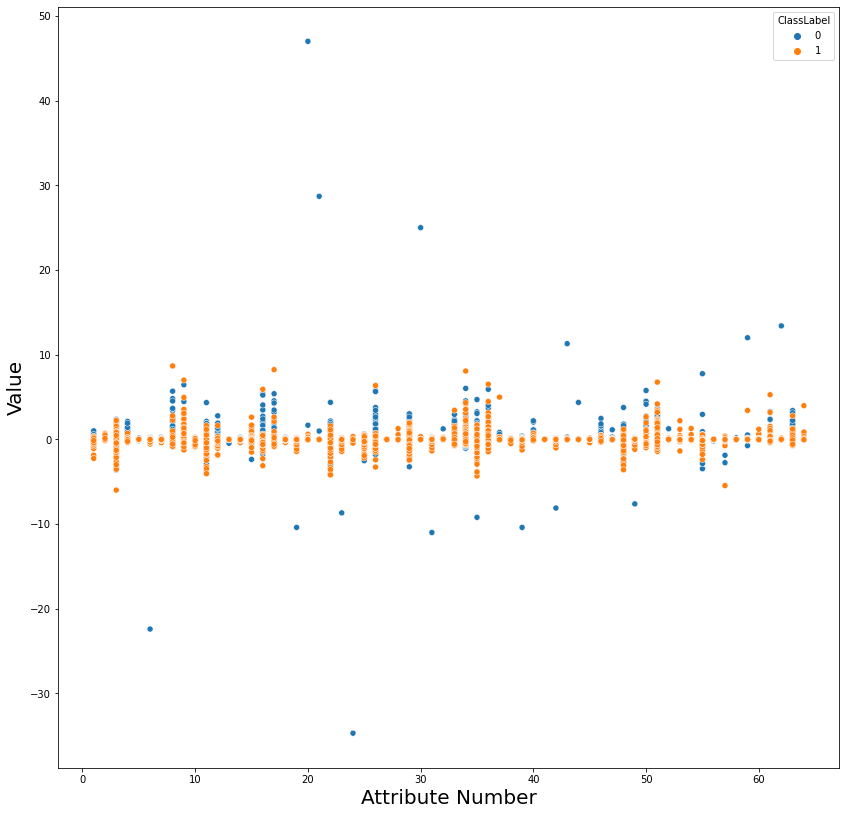

In [ ]:
figure = plt.figure(figsize=(14, 14))
i = 1
for column in bankrupcy.columns[:-1]:
    if i == 1:
    sns.scatterplot(data=bankrupcy, x=np.repeat(i, len(bankrupcy)), y=column, hue='ClassLabel')
    else:
    sns.scatterplot(data=bankrupcy, x=np.repeat(i, len(bankrupcy)), y=column, hue='ClassLabel', legend=None)
    i+=1
plt.xlabel('Attribute Number', fontsize=20)
plt.ylabel('Value', fontsize=20)
plt.show()

In [ ]:
bankrupcy_std = (bankrupcy.iloc[:, :-1] - bankrupcy.iloc[:, :-1].mean())/bankrupcy.iloc[:, :-1].std()
bankrupcy_std['ClassLabel'] = bankrupcy['ClassLabel']

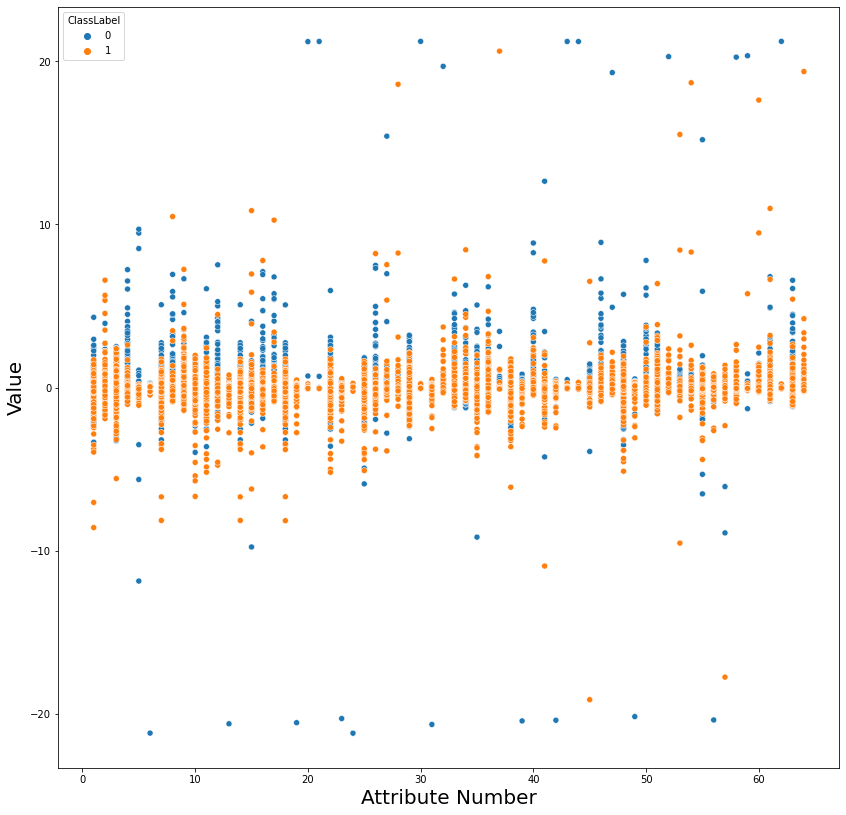

In [ ]:
figure = plt.figure(figsize=(14, 14))
i = 1
for column in bankrupcy.columns[:-1]:
  if i == 1:
    sns.scatterplot(data=bankrupcy_std, x=np.repeat(i, len(bankrupcy)), y=column, hue='ClassLabel')
  else:
    sns.scatterplot(data=bankrupcy_std, x=np.repeat(i, len(bankrupcy)), y=column, hue='ClassLabel', legend=None)
  i+=1
plt.xlabel('Attribute Number', fontsize=20)
plt.ylabel('Value', fontsize=20)
plt.show()

In [ ]:
# Correlation table
bankrupcy_corr = bankrupcy.corr()
bankrupcy_corr

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,attribute10,attribute11,attribute12,attribute13,attribute14,attribute15,attribute16,attribute17,attribute18,attribute19,attribute20,attribute21,attribute22,attribute23,attribute24,attribute25,attribute26,attribute27,attribute28,attribute29,attribute30,attribute31,attribute32,attribute33,attribute34,attribute35,attribute36,attribute37,attribute38,attribute39,attribute40,attribute41,attribute42,attribute43,attribute44,attribute45,attribute46,attribute47,attribute48,attribute49,attribute50,attribute51,attribute52,attribute53,attribute54,attribute55,attribute56,attribute57,attribute58,attribute59,attribute60,attribute61,attribute62,attribute63,attribute64,ClassLabel
attribute1,1.000000,-0.368068,0.336251,0.265596,0.030680,0.019219,0.992661,0.222475,0.117261,0.384063,0.939870,0.755404,0.184800,0.992659,0.051549,0.633750,0.216211,0.992671,0.191729,-0.012648,0.000646,0.922822,0.220866,0.022295,0.459796,0.626725,0.221535,0.024390,0.018403,-0.011686,0.183750,-0.088390,0.277262,0.125868,0.793342,0.155001,0.021650,0.296106,0.178550,0.191805,0.071693,0.190896,-0.010666,-0.007259,0.228618,0.307733,-0.059669,0.870583,0.198563,0.263625,-0.274585,-0.071209,0.086411,0.022728,0.114707,0.130066,0.169502,-0.189025,-0.016159,0.017156,0.023171,-0.012462,0.358401,0.002298,-0.275046
attribute2,-0.368068,1.000000,-0.632313,-0.453199,-0.044202,-0.049855,-0.374551,-0.593418,0.152537,-0.993199,-0.291059,-0.365712,-0.082420,-0.374535,-0.023537,-0.427593,-0.599579,-0.374619,-0.077286,0.006981,-0.044262,-0.283936,-0.086162,-0.045418,-0.786558,-0.413777,-0.088723,-0.060770,-0.143998,0.014294,-0.071872,0.110066,-0.427951,-0.215292,-0.288450,0.109328,0.002235,-0.733557,-0.068281,-0.368564,-0.000592,-0.063236,0.007597,0.008666,-0.085263,-0.424798,0.006314,-0.250109,-0.056375,-0.560930,0.735088,0.106384,-0.258338,-0.066946,-0.191870,-0.071817,-0.084682,0.070429,0.074950,0.023972,0.052133,0.014649,-0.447783,0.087644,0.323921
attribute3,0.336251,-0.632313,1.000000,0.671794,0.126682,0.032082,0.359573,0.388465,-0.057316,0.628710,0.360140,0.360019,0.080196,0.359572,0.069099,0.363649,0.390709,0.359624,0.082612,-0.025749,0.035209,0.351028,0.084491,0.033165,0.548258,0.340185,0.088980,0.224448,-0.041269,-0.038431,0.078174,-0.159070,0.466478,0.179035,0.354592,-0.015005,-0.045210,0.640376,0.089125,0.456839,0.022177,0.084363,-0.026309,-0.027246,0.101058,0.593187,0.051503,0.344859,0.086705,0.637392,-0.651183,-0.160060,0.274713,0.217596,0.328243,0.085549,0.062150,-0.084256,-0.061013,-0.135181,-0.203062,-0.041794,0.494766,0.093876,-0.267652
attribute4,0.265596,-0.453199,0.671794,1.000000,0.063052,0.029544,0.282638,0.621498,-0.072784,0.452207,0.279820,0.574149,0.077806,0.282634,0.004218,0.564193,0.620158,0.282619,0.074540,-0.023613,0.052623,0.262241,0.076717,0.031796,0.371587,0.546165,0.045065,0.101364,-0.028258,-0.034312,0.072925,-0.123630,0.661948,0.289098,0.247757,-0.082982,0.002893,0.511791,0.081259,0.783049,-0.014483,0.075770,-0.025393,-0.028464,0.069910,0.891412,0.048967,0.245125,0.070983,0.771292,-0.519690,-0.121796,0.132210,0.099508,0.174683,0.076811,0.053479,-0.079083,-0.027049,-0.072947,-0.108968,-0.036924,0.726561,0.000279,-0.271784
attribute5,0.030680,-0.044202,0.126682,0.063052,1.000000,0.002026,0.033146,0.029315,0.049680,0.044242,0.033048,0.035093,0.268983,0.033137,0.044797,0.032898,0.029444,0.033114,0.269978,-0.265909,0.001096,0.046778,0.267261,0.003432,0.040537,0.031264,0.010978,0.006796,-0.087396,-0.267831,0.270356,-0.298663,0.057853,0.035815,0.027251,0.050391,-0.003760,0.044471,0.269582,0.038801,0.114099,0.272088,-0.265224,-0.263829,0.008733,0.061371,-0.249812,0.040129,0.271635,0.060508,-0.053464,-0.302652,0.012472,0.005927,0.096387,0.255754,0.007619,-0.259905,-0.002216,0.003155,-0.114400,-0.268884,0.057917,0.000093,-0.049772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

## Default condition - compare SGD and GD

### Gradient Descent:

In [ ]:
learning_rates = [10, 1, 0.1, 0.01, 0.001]
X = bankrupcy.to_numpy()[:, :-1]
y = bankrupcy.to_numpy()[:, -1]
# Split into train/test sets
np.random.seed(0)
indices = np.random.permutation(X.shape[0])
X = X[indices]
y = y[indices]
# Standardization
my_sc = MyStandardScaler()
# Using 10-folds cross-validation to get the accuracies
for learning_rate in learning_rates:
  print("Learning rate: {}".format(learning_rate))
  my_lr = LogisticRegressionSGD(learning_rate = learning_rate, lr_schedule=None, max_iter=10000, tolerance=1e-4, SGD=False)
  my_cv = KFoldCV(my_lr, scaler=my_sc, verbose=1, random_state=0)
  start = time.time()
  my_cv.fit(X, y)
  end = time.time()
  print("Average accuracy: {:.2f}".format(np.array(my_cv.accuracy_scores).mean()))
  print("Time consumed to converge: {:.2f}".format(end - start))
  print("\n")

Learning rate: 10
CV: 1 -> Accuracy: 0.64
CV: 2 -> Accuracy: 0.76
CV: 3 -> Accuracy: 0.73
CV: 4 -> Accuracy: 0.76
CV: 5 -> Accuracy: 0.80
CV: 6 -> Accuracy: 0.78
CV: 7 -> Accuracy: 0.69
CV: 8 -> Accuracy: 0.76
CV: 9 -> Accuracy: 0.87
CV: 10 -> Accuracy: 0.71
Average accuracy: 0.75
Time consumed to converge: 2.85


Learning rate: 1
CV: 1 -> Accuracy: 0.73
CV: 2 -> Accuracy: 0.71
CV: 3 -> Accuracy: 0.76
CV: 4 -> Accuracy: 0.76
CV: 5 -> Accuracy: 0.58
CV: 6 -> Accuracy: 0.71
CV: 7 -> Accuracy: 0.69
CV: 8 -> Accuracy: 0.73
CV: 9 -> Accuracy: 0.78
CV: 10 -> Accuracy: 0.69
Average accuracy: 0.71
Time consumed to converge: 0.77


Learning rate: 0.1
CV: 1 -> Accuracy: 0.80
CV: 2 -> Accuracy: 0.73
CV: 3 -> Accuracy: 0.78
CV: 4 -> Accuracy: 0.78
CV: 5 -> Accuracy: 0.56
CV: 6 -> Accuracy: 0.84
CV: 7 -> Accuracy: 0.76
CV: 8 -> Accuracy: 0.73
CV: 9 -> Accuracy: 0.76
CV: 10 -> Accuracy: 0.73
Average accuracy: 0.75
Time consumed to converge: 6.95


Learning rate: 0.01
CV: 1 -> Accuracy: 0.78
CV: 2 ->

In [ ]:
my_lr = LogisticRegressionSGD(learning_rate = 0.1, max_iter=10000, tolerance=1e-4, SGD=False)
my_sc = MyStandardScaler()
my_cv = KFoldCV(my_lr, scaler=my_sc, verbose=1, random_state=0)
start = time.time()
my_cv.fit(X, y)
end = time.time()
print("Average accuracy: {:.2f}".format(np.array(my_cv.accuracy_scores).mean()))
print("Time consumed to converge: {:.2f}".format(end - start))
print("\n")

CV: 1 -> Accuracy: 0.80
CV: 2 -> Accuracy: 0.82
CV: 3 -> Accuracy: 0.84
CV: 4 -> Accuracy: 0.82
CV: 5 -> Accuracy: 0.78
CV: 6 -> Accuracy: 0.84
CV: 7 -> Accuracy: 0.76
CV: 8 -> Accuracy: 0.76
CV: 9 -> Accuracy: 0.82
CV: 10 -> Accuracy: 0.79
Average accuracy: 0.80
Time consumed to converge: 38.82




### Stochastic Gradient Descent

In [ ]:
# Using 10-folds cross-validation to get the accuracies
my_lr = LogisticRegressionSGD(learning_rate = 0.1, max_iter=10000, tolerance=1e-4, SGD=True)
my_sc = MyStandardScaler()
my_cv = KFoldCV(my_lr, scaler=my_sc, verbose=1, random_state=0)
start = time.time()
my_cv.fit(X, y)
end = time.time()
print("Average accuracy: {:.2f}".format(np.array(my_cv.accuracy_scores).mean()))
print("Time consumed to converge: {:.2f}".format(end - start))
print("\n")

CV: 1 -> Accuracy: 0.73
CV: 2 -> Accuracy: 0.78
CV: 3 -> Accuracy: 0.82
CV: 4 -> Accuracy: 0.78
CV: 5 -> Accuracy: 0.76
CV: 6 -> Accuracy: 0.76
CV: 7 -> Accuracy: 0.73
CV: 8 -> Accuracy: 0.76
CV: 9 -> Accuracy: 0.87
CV: 10 -> Accuracy: 0.73
Average accuracy: 0.77
Time consumed to converge: 102.08




As shown above, normal gradient descent works better than stochastic gradient descent for this dataset, both on accuracy and on running time!

## Remove Columns With Strong Colinearity
Colinearity in features can cause model to become unsteady. In addition, it may result in failures of converging to a local minimal. In the cell below, I experimented with different threshold values to remove the attributes that have correlation values above the thresholds. The training time and the 10 folds cross-validation accuracies were compared.

In [ ]:
# Colinearity Threshold
threshold = 0.9
for column in bankrupcy.columns:
  s = abs(bankrupcy_corr[column]) > threshold
  co_columns = s[s].index.tolist()
  print("{} has strong colinearity with {}".format(column, co_columns))

attribute1 has strong colinearity with ['attribute1', 'attribute7', 'attribute11', 'attribute14', 'attribute18', 'attribute22']
attribute2 has strong colinearity with ['attribute2', 'attribute10']
attribute3 has strong colinearity with ['attribute3']
attribute4 has strong colinearity with ['attribute4']
attribute5 has strong colinearity with ['attribute5']
attribute6 has strong colinearity with ['attribute6', 'attribute24']
attribute7 has strong colinearity with ['attribute1', 'attribute7', 'attribute11', 'attribute14', 'attribute18', 'attribute22']
attribute8 has strong colinearity with ['attribute8', 'attribute17']
attribute9 has strong colinearity with ['attribute9']
attribute10 has strong colinearity with ['attribute2', 'attribute10']
attribute11 has strong colinearity with ['attribute1', 'attribute7', 'attribute11', 'attribute14', 'attribute18', 'attribute22', 'attribute48']
attribute12 has strong colinearity with ['attribute12']
attribute13 has strong colinearity with ['attribute

As can be seen from the above results, many columns in bankrupcy dataset has colinearity with each other. The colinearity may cause trouble for convergence. Therefore we can try remove them to see if it improves the accuracy.

In [ ]:
import time
thresholds = [0.75, 0.8, 0.85, 0.88, 0.9, 0.92, 0.95, 0.97, 0.98, 0.99, 1]
# Exclude the columns that have strong colinearity
for threshold in  thresholds:
  bankrupcy_corr_new = bankrupcy_corr
  for column in bankrupcy.columns[:-1]:
    bankrupcy_corr_new = bankrupcy_corr_new.loc[(abs(bankrupcy_corr_new[column]) < threshold) | (bankrupcy_corr_new[column]==1)]
  new_columns = bankrupcy_corr_new.index.tolist()
  bankrupcy_new = bankrupcy.loc[:, new_columns]
  print("Threshold value: {}".format(threshold))
  print("Number of columns for the new dataset: {}".format(len(bankrupcy_new.columns)))
  X = bankrupcy_new.to_numpy()[:, :-1]
  y = bankrupcy_new.to_numpy()[:, -1]
  # Split into train/test sets
  np.random.seed(0)
  indices = np.random.permutation(X.shape[0])
  X = X[indices]
  y = y[indices]
  # Standardization
  my_sc = MyStandardScaler()
  # Using 10-folds cross-validation to get the accuracies
  my_lr = LogisticRegressionSGD(learning_rate = 0.005, max_iter=10000, tolerance=1e-4)
  my_cv = KFoldCV(my_lr, scaler=my_sc, random_state=0)
  start = time.time()
  my_cv.fit(X, y)
  end = time.time()
  print("Average accuracy: {:.2f}".format(np.array(my_cv.accuracy_scores).mean()))
  print("Time consumed to converge: {:.2f}".format(end - start))
  print("\n")

Threshold value: 0.75
Number of columns for the new dataset: 16
Average accuracy: 0.66
Time consumed to converge: 0.31


Threshold value: 0.8
Number of columns for the new dataset: 18
Average accuracy: 0.68
Time consumed to converge: 0.39


Threshold value: 0.85
Number of columns for the new dataset: 18
Average accuracy: 0.68
Time consumed to converge: 0.40


Threshold value: 0.88
Number of columns for the new dataset: 20
Average accuracy: 0.70
Time consumed to converge: 0.35


Threshold value: 0.9
Number of columns for the new dataset: 25
Average accuracy: 0.72
Time consumed to converge: 1.48


Threshold value: 0.92
Number of columns for the new dataset: 26
Average accuracy: 0.73
Time consumed to converge: 1.57


Threshold value: 0.95
Number of columns for the new dataset: 29
Average accuracy: 0.75
Time consumed to converge: 1.83


Threshold value: 0.97
Number of columns for the new dataset: 33
Average accuracy: 0.74
Time consumed to converge: 2.41


Threshold value: 0.98
Number of co

Based on the above results, a threshold value of 0.95 significantly decreased the running time. It had even lower running time than the datasets with fewer feature columns. However, there was also a drop in accuracy value compared to a threshold value of 1 (no feature removal). 

## Remove Columns With Weak Correlation With The ClassLabel Column
Another way to remove unnecessary feature columns is to drop the features that do not have strong correlation with the ClassLabel column. In the cell below, I experimented with different threshold values and obtained the running time and 10-fold cross-validation accuracy for each threshold. 

In [ ]:
thresholds = [0, 0.1, 0.2, 0.25, 0.3]
for threshold in thresholds:
  bankrupcy_corr_new = bankrupcy_corr
  new_columns = bankrupcy_corr_new.loc[abs(bankrupcy_corr_new["ClassLabel"])>threshold].index.tolist()
  removed_columns = bankrupcy_corr_new.loc[abs(bankrupcy_corr_new["ClassLabel"])<=threshold].index.tolist()
  bankrupcy_new = bankrupcy.loc[:, new_columns]
  print("Threshold value: {}".format(threshold))
  print("Columns removed: {}".format(removed_columns))
  print("Number of columns for the new dataset: {}".format(len(bankrupcy_new.columns)))
  X = bankrupcy_new.to_numpy()[:, :-1]
  y = bankrupcy_new.to_numpy()[:, -1]
  # Split into train/test sets
  np.random.seed(0)
  indices = np.random.permutation(X.shape[0])
  X = X[indices]
  y = y[indices]
  # Standardization
  my_sc = MyStandardScaler()
  # Using 10-folds cross-validation to get the accuracies
  my_lr = LogisticRegressionSGD(learning_rate = 0.005, max_iter=5000, tolerance=1e-4)
  my_cv = KFoldCV(my_lr, scaler=my_sc, random_state=0)
  start = time.time()
  my_cv.fit(X, y)
  end = time.time()
  print("Average accuracy: {:.2f}".format(np.array(my_cv.accuracy_scores).mean()))
  print("Time consumed to converge: {:.2f}".format(end - start))
  print("\n")

Threshold value: 0
Columns removed: []
Number of columns for the new dataset: 65
Average accuracy: 0.81
Time consumed to converge: 31.04


Threshold value: 0.1
Columns removed: ['attribute5', 'attribute6', 'attribute13', 'attribute15', 'attribute19', 'attribute20', 'attribute21', 'attribute23', 'attribute24', 'attribute27', 'attribute28', 'attribute30', 'attribute31', 'attribute32', 'attribute36', 'attribute37', 'attribute39', 'attribute41', 'attribute42', 'attribute43', 'attribute44', 'attribute45', 'attribute47', 'attribute49', 'attribute52', 'attribute53', 'attribute54', 'attribute55', 'attribute56', 'attribute57', 'attribute58', 'attribute59', 'attribute60', 'attribute61', 'attribute62', 'attribute64']
Number of columns for the new dataset: 29
Average accuracy: 0.77
Time consumed to converge: 11.65


Threshold value: 0.2
Columns removed: ['attribute5', 'attribute6', 'attribute9', 'attribute13', 'attribute15', 'attribute19', 'attribute20', 'attribute21', 'attribute23', 'attribute24'

As shown from the above results, until a threshold value of 0.2, even though the number of features significantly dropped through removing the columns that did not have strong correlations with the ClassLabel column, the accuracy did not change. This means that I indeed removed irrelevant columns. However, the running time also did not decrease. This is probably because colinearity still exists between the features, results in a hard time for the model to converge. When the threshold value is above 0.25, I just removed too many features so that the model accuracy dropped significantly.

## Combine Two Methods

In [ ]:
colinearity_threshold = 0.95
correlation_threshold = 0.2
bankrupcy_corr_new = bankrupcy_corr
for column in bankrupcy.columns[:-1]:
  bankrupcy_corr_new = bankrupcy_corr_new.loc[(abs(bankrupcy_corr_new[column]) < colinearity_threshold) | (bankrupcy_corr_new[column]==1)]
bankrupcy_corr_new = bankrupcy_corr_new.loc[abs(bankrupcy_corr_new["ClassLabel"])>correlation_threshold]
new_columns = bankrupcy_corr_new.index.tolist()
bankrupcy_new = bankrupcy.loc[:, new_columns]
print("Number of columns for the new dataset: {}".format(len(bankrupcy_new.columns)))
X = bankrupcy_new.to_numpy()[:, :-1]
y = bankrupcy_new.to_numpy()[:, -1]
np.random.seed(0)
indices = np.random.permutation(X.shape[0])
X = X[indices]
y = y[indices]
# Standardization
my_sc = MyStandardScaler()
# Using 10-folds cross-validation to get the accuracies
my_lr = LogisticRegressionSGD(learning_rate = 0.01, max_iter=5000, tolerance=1e-4)
my_cv = KFoldCV(my_lr, scaler=my_sc, random_state=0)
start = time.time()
my_cv.fit(X, y)
end = time.time()
print("Average accuracy: {:.2f}".format(np.array(my_cv.accuracy_scores).mean()))
print("Time consumed to converge: {:.2f}".format(end - start))
print("\n")

Number of columns for the new dataset: 8
Average accuracy: 0.74
Time consumed to converge: 0.17




Now I successfully limit the number of columns to 8 without impacting largely the accuracy. The running time goes down to **1/300** of the original running time!

## Test Nonlinear Correlations
I can just work with the 7 attributes I obtained above.

In [ ]:
bankrupcy_new.head()

,attribute3,attribute4,attribute12,attribute25,attribute35,attribute46,attribute50,ClassLabel
0,-0.0403,-0.0135,-0.0366,0.0502,-0.436,0.1470,-0.192,0
1,0.3040,-0.0810,-0.3000,0.2740,-0.986,-0.0135,0.187,0
2,-0.4880,-0.1890,-0.1510,-0.1140,0.766,-0.2350,-0.469,0
3,-0.1820,-0.1400,-0.1460,-0.1060,-0.100,-0.0679,-0.515,0
4,0.6780,-0.0147,0.2090,-0.1280,1.000,0.0499,0.343,0


In [ ]:
bankrupcy_nonlinear = bankrupcy_new
i = 0
feature_columns = bankrupcy_nonlinear.columns[:-1]
while i < len(feature_columns):
  for j in range(i, len(feature_columns)):
    column_name = feature_columns[i] + ' * ' + feature_columns[j]
    bankrupcy_nonlinear[column_name] = bankrupcy_nonlinear.iloc[:, i] * bankrupcy_nonlinear.iloc[:, j]
  i += 1

In [ ]:
# Rearrange dataframe to move the ClassLabel column to the end
new_feature_columns = list(bankrupcy_nonlinear.columns.values)
new_feature_columns.pop(new_feature_columns.index('ClassLabel'))
new_feature_columns = new_feature_columns + ['ClassLabel']
bankrupcy_nonlinear = bankrupcy_nonlinear[new_feature_columns]

In [ ]:
bankrupcy_nonlinear_corr = bankrupcy_nonlinear.corr()
colinearity_threshold = 0.95
correlation_threshold = 0.2
bankrupcy_corr_new = bankrupcy_nonlinear_corr
for column in bankrupcy_nonlinear.columns[:-1]:
  bankrupcy_corr_new = bankrupcy_corr_new.loc[(abs(bankrupcy_corr_new[column]) < colinearity_threshold) | (bankrupcy_corr_new[column]==1)]
bankrupcy_corr_new = bankrupcy_corr_new.loc[abs(bankrupcy_corr_new["ClassLabel"])>correlation_threshold]
new_columns = bankrupcy_corr_new.index.tolist()
bankrupcy_new = bankrupcy.loc[:, new_columns]
print("Number of columns for the new dataset: {}".format(len(bankrupcy_new.columns)))
X = bankrupcy_new.to_numpy()[:, :-1]
y = bankrupcy_new.to_numpy()[:, -1]
np.random.seed(0)
indices = np.random.permutation(X.shape[0])
X = X[indices]
y = y[indices]
# Standardization
my_sc = MyStandardScaler()
# Using 10-folds cross-validation to get the accuracies
my_lr = LogisticRegressionSGD(learning_rate = 0.01, max_iter=5000, tolerance=1e-4)
my_cv = KFoldCV(my_lr, scaler=my_sc, random_state=0)
start = time.time()
my_cv.fit(X, y)
end = time.time()
print("Average accuracy: {:.2f}".format(np.array(my_cv.accuracy_scores).mean()))
print("Time consumed to converge: {:.2f}".format(end - start))
print("\n")

Number of columns for the new dataset: 8
Average accuracy: 0.74
Time consumed to converge: 0.17




Not much improvement...

# Hepatitis

In [ ]:
hepatitis = pd.read_csv(r"/content/drive/My Drive/ECSE 551 Group 3/Assignment 1/hepatitis.csv")


In [ ]:
hepatitis.head()

,age,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palable,spiders,ascites,varices,bilirubin,alk_phosphate,sgot,albumin,protime,histology,ClassLabel
0,30,2,1,2,2,2,2,1,2,2,2,2,2,1.0,85,18,4.0,61,1,1
1,50,1,1,2,1,2,2,1,2,2,2,2,2,0.9,135,42,3.5,61,1,1
2,78,1,2,2,1,2,2,2,2,2,2,2,2,0.7,96,32,4.0,61,1,1
3,34,1,2,2,2,2,2,2,2,2,2,2,2,1.0,105,200,4.0,61,1,1
4,34,1,2,2,2,2,2,2,2,2,2,2,2,0.9,95,28,4.0,75,1,1


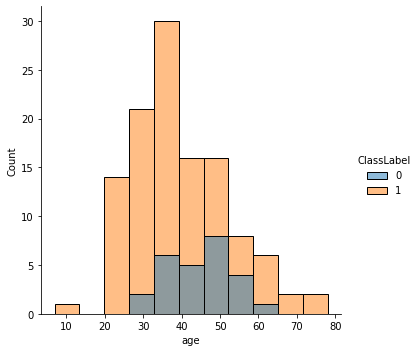

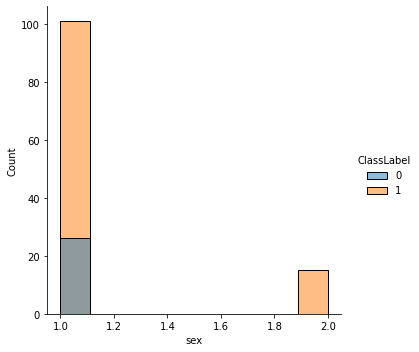

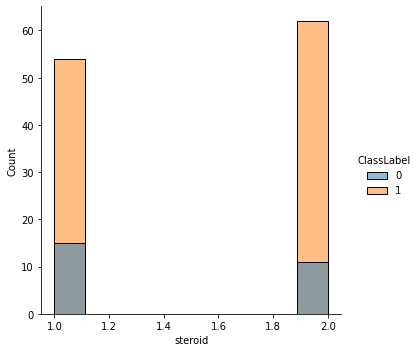

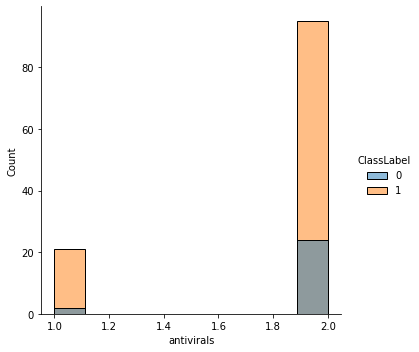

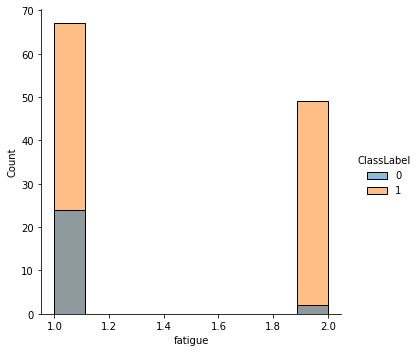

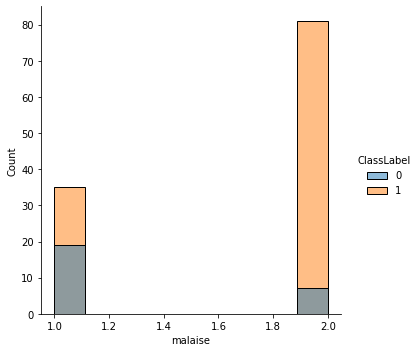

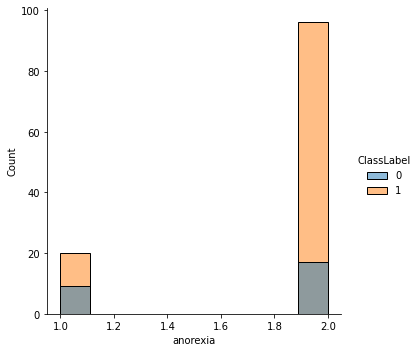

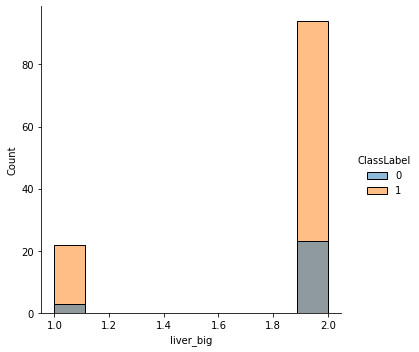

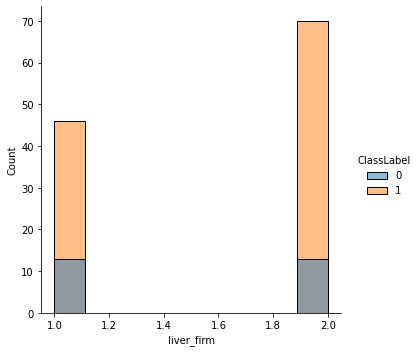

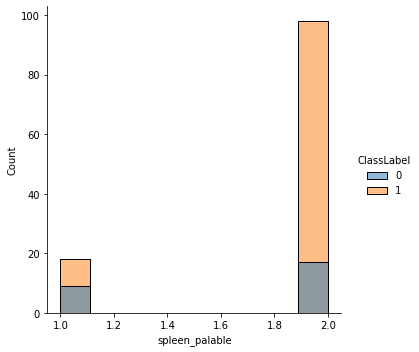

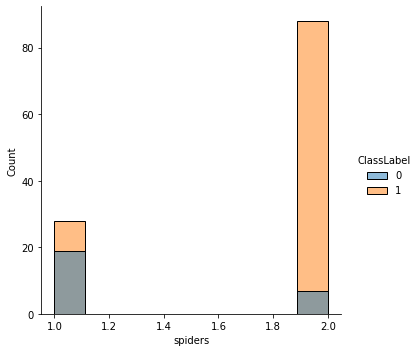

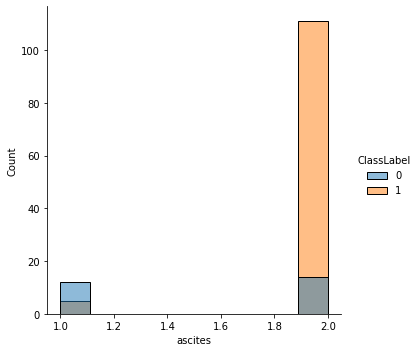

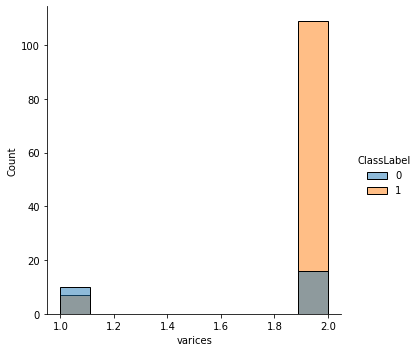

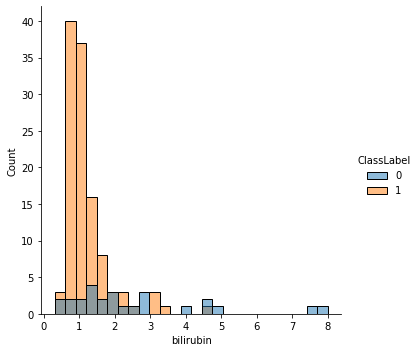

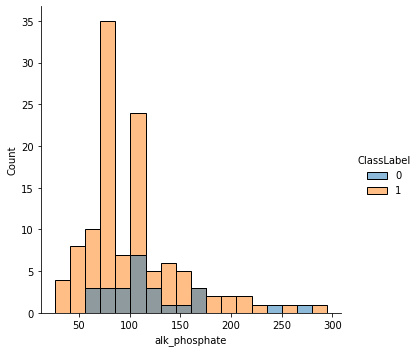

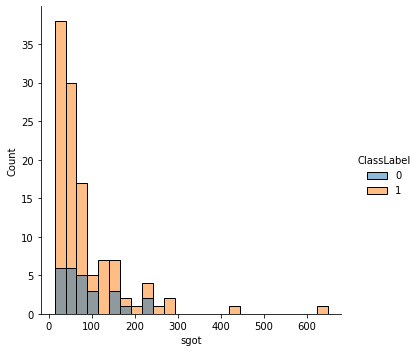

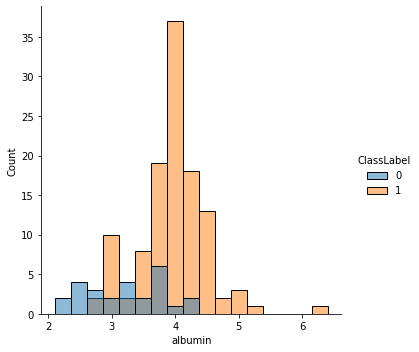

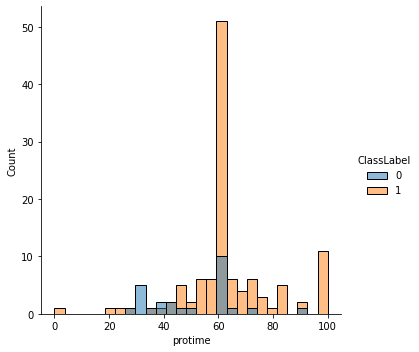

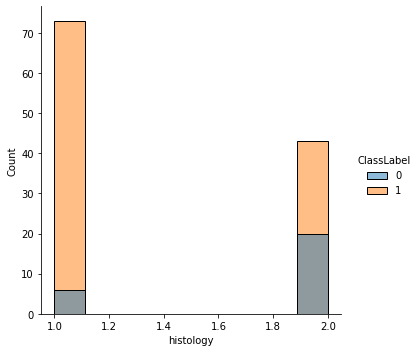

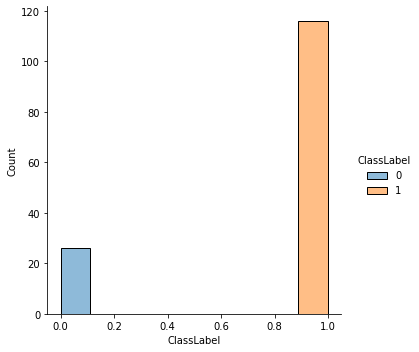

In [ ]:
for column in hepatitis.columns:
  sns.displot(data=hepatitis, x=column, hue='ClassLabel')

In [ ]:
# Correlation table
hepatitis_corr = hepatitis.corr()
hepatitis_corr

,age,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palable,spiders,ascites,varices,bilirubin,alk_phosphate,sgot,albumin,protime,histology,ClassLabel
age,1.000000,-0.028773,-0.022776,-0.044396,-0.243713,-0.033306,0.120364,-0.112006,-0.088006,-0.075270,-0.197884,-0.087715,-0.055567,0.147050,-0.030141,-0.013709,-0.216044,-0.127427,0.181512,-0.160050
sex,-0.028773,1.000000,-0.032605,-0.097661,-0.066254,-0.013959,0.003602,-0.081761,-0.082179,-0.067021,-0.050403,0.126740,0.056163,-0.050150,0.039448,-0.005748,0.032088,-0.011126,-0.122436,0.162705
steroid,-0.022776,-0.032605,1.000000,0.069755,0.140436,0.225246,0.101654,0.216497,0.095238,0.067514,0.034793,-0.054713,-0.054713,-0.065891,-0.002476,-0.026080,0.178985,0.063595,-0.096067,0.086206
antivirals,-0.044396,-0.097661,0.069755,1.000000,-0.029461,0.009982,-0.033057,0.047713,0.094782,-0.164311,-0.146747,-0.162129,-0.162129,0.169175,0.186619,0.103492,-0.161645,-0.010626,0.200227,-0.109289
fatigue,-0.243713,-0.066254,0.140436,-0.029461,1.000000,0.586435,0.379249,0.114808,0.273741,0.175707,0.370594,0.276079,0.185645,-0.299168,-0.130298,-0.187825,0.293016,0.194021,-0.136702,0.278514
malaise,-0.033306,-0.013959,0.225246,0.009982,0.586435,1.000000,0.610718,0.056864,0.134330,0.027075,0.343011,0.336718,0.202660,-0.342195,-0.184377,-0.180630,0.301391,0.183469,-0.147228,0.341807
anorexia,0.120364,0.003602,0.101654,-0.033057,0.379249,0.610718,1.000000,0.086886,0.104595,0.066147,0.311883,0.189854,0.189854,-0.362389,-0.169926,-0.171502,0.174548,0.029146,-0.075028,0.166678
liver_big,-0.112006,-0.081761,0.216497,0.047713,0.114808,0.056864,0.086886,1.000000,0.435705,0.105851,0.224966,-0.113513,-0.056556,-0.008686,-0.124866,0.043604,-0.049763,-0.066471,-0.071027,-0.075417
liver_firm,-0.088006,-0.082179,0.095238,0.094782,0.273741,0.134330,0.104595,0.435705,1.000000,0.137714,0.318006,0.085249,0.173288,-0.126936,-0.348345,-0.191415,0.187444,0.049877,-0.167516,0.081185
spleen_palable,-0.075270,-0.067021,0.067514,-0.164311,0.175707,0.027075,0.066147,0.105851,0.137714,1.000000,0.269376,0.042434,0.208278,-0.160564,-0.270479,-0.004001,0.191526,0.108906,-0.181374,0.188224


In [ ]:
# Colinearity Threshold
threshold = 0.7
for column in hepatitis.columns:
  s = abs(hepatitis_corr[column]) > threshold
  co_columns = s[s].index.tolist()
  print("{} has strong colinearity with {}".format(column, co_columns))

age has strong colinearity with ['age']
sex has strong colinearity with ['sex']
steroid has strong colinearity with ['steroid']
antivirals has strong colinearity with ['antivirals']
fatigue has strong colinearity with ['fatigue']
malaise has strong colinearity with ['malaise']
anorexia has strong colinearity with ['anorexia']
liver_big has strong colinearity with ['liver_big']
liver_firm has strong colinearity with ['liver_firm']
spleen_palable has strong colinearity with ['spleen_palable']
spiders has strong colinearity with ['spiders']
ascites has strong colinearity with ['ascites']
varices has strong colinearity with ['varices']
bilirubin has strong colinearity with ['bilirubin']
alk_phosphate has strong colinearity with ['alk_phosphate']
sgot has strong colinearity with ['sgot']
albumin has strong colinearity with ['albumin']
protime has strong colinearity with ['protime']
histology has strong colinearity with ['histology']
ClassLabel has strong colinearity with ['ClassLabel']


No strong colinearity found between features.

## Remove Columns With Weak Correlations

In [ ]:
thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
for threshold in thresholds:
  hepatitis_corr_new = hepatitis_corr
  new_columns = hepatitis_corr_new.loc[abs(hepatitis_corr_new["ClassLabel"])>threshold].index.tolist()
  removed_columns = hepatitis_corr_new.loc[abs(hepatitis_corr_new["ClassLabel"])<=threshold].index.tolist()
  hepatitis_new = hepatitis.loc[:, new_columns]
  print("Threshold value: {}".format(threshold))
  print("Columns removed: {}".format(removed_columns))
  print("Number of columns for the new dataset: {}".format(len(hepatitis_new.columns)))
  X = hepatitis_new.to_numpy()[:, :-1]
  y = hepatitis_new.to_numpy()[:, -1]
  # Split into train/test sets
  np.random.seed(0)
  indices = np.random.permutation(X.shape[0])
  X = X[indices]
  y = y[indices]
  # Standardization
  my_sc = MyStandardScaler()
  # Using 10-folds cross-validation to get the accuracies
  my_lr = LogisticRegressionSGD(learning_rate = 0.01, max_iter=5000, tolerance=1e-4)
  my_cv = KFoldCV(my_lr, scaler=my_sc, random_state=0)
  start = time.time()
  my_cv.fit(X, y)
  end = time.time()
  # print("Weights: {}".format(my_lr.w))
  print("Average accuracy: {:.2f}".format(np.array(my_cv.accuracy_scores).mean()))
  print("Time consumed to converge: {:.2f}".format(end - start))
  print("\n")

Threshold value: 0
Columns removed: []
Number of columns for the new dataset: 20
Average accuracy: 0.83
Time consumed to converge: 0.38


Threshold value: 0.1
Columns removed: ['steroid', 'liver_big', 'liver_firm', 'sgot']
Number of columns for the new dataset: 16
Average accuracy: 0.85
Time consumed to converge: 0.27


Threshold value: 0.2
Columns removed: ['age', 'sex', 'steroid', 'antivirals', 'anorexia', 'liver_big', 'liver_firm', 'spleen_palable', 'alk_phosphate', 'sgot']
Number of columns for the new dataset: 10
Average accuracy: 0.85
Time consumed to converge: 0.12


Threshold value: 0.3
Columns removed: ['age', 'sex', 'steroid', 'antivirals', 'fatigue', 'anorexia', 'liver_big', 'liver_firm', 'spleen_palable', 'alk_phosphate', 'sgot', 'protime']
Number of columns for the new dataset: 8
Average accuracy: 0.85
Time consumed to converge: 0.11


Threshold value: 0.4
Columns removed: ['age', 'sex', 'steroid', 'antivirals', 'fatigue', 'malaise', 'anorexia', 'liver_big', 'liver_firm', 

Try nonlinear combinations

In [ ]:
threshold = 0.4
hepatitis_corr_new = hepatitis_corr
new_columns = hepatitis_corr_new.loc[abs(hepatitis_corr_new["ClassLabel"])>threshold].index.tolist()
removed_columns = hepatitis_corr_new.loc[abs(hepatitis_corr_new["ClassLabel"])<=threshold].index.tolist()
hepatitis_new = hepatitis.loc[:, new_columns]
i = 0
feature_columns = hepatitis_new.columns[:-1]
while i < len(feature_columns):
  for j in range(i, len(feature_columns)):
    column_name = feature_columns[i] + ' * ' + feature_columns[j]
    hepatitis_new[column_name] = hepatitis_new.iloc[:, i] * hepatitis_new.iloc[:, j]
  i += 1
# Rearrange dataframe to move the ClassLabel column to the end
new_feature_columns = list(hepatitis_new.columns.values)
new_feature_columns.pop(new_feature_columns.index('ClassLabel'))
new_feature_columns = new_feature_columns + ['ClassLabel']
hepatitis_new = hepatitis_new[new_feature_columns]

In [ ]:
hepatitis_new.head()

,spiders,ascites,bilirubin,albumin,spiders * spiders,spiders * ascites,spiders * bilirubin,spiders * albumin,ascites * ascites,ascites * bilirubin,ascites * albumin,bilirubin * bilirubin,bilirubin * albumin,albumin * albumin,ClassLabel
0,2,2,1.0,4.0,4,4,2.0,8.0,4,2.0,8.0,1.00,4.00,16.00,1
1,2,2,0.9,3.5,4,4,1.8,7.0,4,1.8,7.0,0.81,3.15,12.25,1
2,2,2,0.7,4.0,4,4,1.4,8.0,4,1.4,8.0,0.49,2.80,16.00,1
3,2,2,1.0,4.0,4,4,2.0,8.0,4,2.0,8.0,1.00,4.00,16.00,1
4,2,2,0.9,4.0,4,4,1.8,8.0,4,1.8,8.0,0.81,3.60,16.00,1


In [ ]:
hepatitis_new_corr = hepatitis_new.corr()
hepatitis_new_corr

,spiders,ascites,bilirubin,albumin,spiders * spiders,spiders * ascites,spiders * bilirubin,spiders * albumin,ascites * ascites,ascites * bilirubin,ascites * albumin,bilirubin * bilirubin,bilirubin * albumin,albumin * albumin,ClassLabel
spiders,1.000000,0.293804,-0.290203,0.296507,1.000000,0.915995,0.119055,0.892549,0.293804,-0.209267,0.346598,-0.204937,-0.285005,0.294521,0.402217
ascites,0.293804,1.000000,-0.305867,0.553608,0.293804,0.630693,-0.150511,0.447184,1.000000,0.026540,0.856360,-0.260786,-0.195114,0.494658,0.498499
bilirubin,-0.290203,-0.305867,1.000000,-0.406031,-0.290203,-0.345315,0.863304,-0.403243,-0.305867,0.907520,-0.417814,0.936792,0.953241,-0.375269,-0.461533
albumin,0.296507,0.553608,-0.406031,1.000000,0.296507,0.473866,-0.332748,0.680289,0.553608,-0.276764,0.898014,-0.342486,-0.198002,0.987491,0.454181
spiders * spiders,1.000000,0.293804,-0.290203,0.296507,1.000000,0.915995,0.119055,0.892549,0.293804,-0.209267,0.346598,-0.204937,-0.285005,0.294521,0.402217
spiders * ascites,0.915995,0.630693,-0.345315,0.473866,0.915995,1.000000,0.034437,0.906951,0.630693,-0.157115,0.624501,-0.251538,-0.294508,0.447591,0.523592
spiders * bilirubin,0.119055,-0.150511,0.863304,-0.332748,0.119055,0.034437,1.000000,-0.072518,-0.150511,0.867975,-0.286853,0.846546,0.781842,-0.294985,-0.282922
spiders * albumin,0.892549,0.447184,-0.403243,0.680289,0.892549,0.906951,-0.072518,1.000000,0.447184,-0.296950,0.660072,-0.312030,-0.305284,0.679384,0.501465
ascites * ascites,0.293804,1.000000,-0.305867,0.553608,0.293804,0.630693,-0.150511,0.447184,1.000000,0.026540,0.856360,-0.260786,-0.195114,0.494658,0.498499
ascites * bilirubin,-0.209267,0.026540,0.907520,-0.276764,-0.209267,-0.157115,0.867975,-0.296950,0.026540,1.000000,-0.167808,0.837833,0.887328,-0.260389,-0.305412


In [ ]:
threshold = 0.4
hepatitis_corr_new = hepatitis_new_corr
new_columns = hepatitis_corr_new.loc[abs(hepatitis_corr_new["ClassLabel"])>threshold].index.tolist()
removed_columns = hepatitis_corr_new.loc[abs(hepatitis_corr_new["ClassLabel"])<=threshold].index.tolist()
hepatitis_new_2 = hepatitis_new.loc[:, new_columns]
print("Columns removed: {}".format(removed_columns))
print("Number of columns for the new dataset: {}".format(len(hepatitis_new_2.columns)))
X = hepatitis_new_2.to_numpy()[:, :-1]
y = hepatitis_new_2.to_numpy()[:, -1]
np.random.seed(0)
indices = np.random.permutation(X.shape[0])
X = X[indices]
y = y[indices]
# Standardization
my_sc = MyStandardScaler()
# Using 10-folds cross-validation to get the accuracies
my_lr = LogisticRegressionSGD(learning_rate = 0.01, max_iter=5000, tolerance=1e-4)
my_cv = KFoldCV(my_lr, scaler=my_sc, random_state=0)
start = time.time()
my_cv.fit(X, y)
end = time.time()
print("Average accuracy: {:.2f}".format(np.array(my_cv.accuracy_scores).mean()))
print("Time consumed to converge: {:.2f}".format(end - start))
print("\n")

Columns removed: ['spiders * bilirubin', 'ascites * bilirubin', 'bilirubin * albumin']
Number of columns for the new dataset: 12
Average accuracy: 0.86
Time consumed to converge: 0.93


